# Simple NCAA Tournament Model
> Testing NCAA tournament models with embeddings generated in my previous post

- toc: true 
- badges: true
- comments: true
- categories: [kaggle]

## Summary of findings
When used as features, embeddings trained on regular season games improve prediction accuracy (slightly) and the log loss (~0.59 vs. ~0.56) of an NCAA Tournament model using a limited data set. 


## Introduction
This is a brief follow up to a my initial post about generating [NCAA embeddings](https://rysarmstr.github.io/Data-Bites-Blog/kaggle/2020/05/04/NCAA-Embeddings.html). The conclusions and insights of the first post were qualitative - we needed to actually build a tournament model to see if the embeddings would be more useful than the statistics they were trained by. In this notebook, I generate three very simple neural networks. The networks are all the same, excluding the inputs.
 - The first is trained using the aggregated win percentage and point differences of each team from the regular season. 
 - The second is trained using the embeddings we generated in the previous post, which have been loaded from disk.
 - The third will be trained using both.


In [ ]:
#collapse_hide
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Multiply, Lambda, Concatenate, Add, Subtract
from keras.layers.embeddings import Embedding
from keras.initializers import glorot_uniform, glorot_normal, Constant
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import TSNE
import altair as alt
np.random.seed(13)

## Input data

As before, we are using the compact game results provided by Kaggle. This data set has limited feature columns, but extends back further than the more detailed data set. This is perfect for our simple proof of concept and will at least give an indication whether this type of model is worth pursuing in more detail. A few rows of our data below:

In [2]:
#collapse_hide
dataLoc=Path('./data/2020-05-04-NCAA-Embeddings/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage2/')

df_teams = pd.read_csv(dataLoc/'MTeams.csv')
teams_dict = df_teams[['TeamID','TeamName']].set_index('TeamID').to_dict()['TeamName']

df_regSeason_data = pd.read_csv(dataLoc/'MRegularSeasonCompactResults.csv')
df_regSeason_data.head() # cols = Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


From these data I generate ID pairs for the tournament match-ups. The regular season data is also aggregated into average values for each team to be used as input.

I'll split out the 2015-2019 data as a test set. This was recently used as the test data for the public Kaggle leaderboard and good models were able to achieve scores in the range of 0.47 to 0.5 log loss. The training and validation are segmented by odd and even seasons. The results don't change much even if I add more seasons to the training data (tested with every third and every 4th as validation as well).

In [3]:
#collapse_hide
# load validation data
df_tourney_data = pd.read_csv(dataLoc/'MNCAATourneyCompactResults.csv')

# Create team encoding that differentiates teams by year and school
def newTeamID(df):
    # df = df.sample(frac=1).reset_index(drop=True)
    df['Wnewid'] = df['Season'].astype(str) + df['WTeamID'].astype(str)
    df['Lnewid'] = df['Season'].astype(str) + df['LTeamID'].astype(str)
    return df

df_regSeason_data = newTeamID(df_regSeason_data)
df_tourney_data = newTeamID(df_tourney_data)

def idDicts(df):
    newid_W = list(df['Wnewid'].unique())
    newid_L = list(df['Lnewid'].unique())
    ids = list(set().union(newid_W,newid_L))
    ids.sort()
    oh_to_id = {}
    id_to_oh = {}
    for i in range(len(ids)):
        id_to_oh[ids[i]] = i 
        oh_to_id[i] = ids[i]

    return oh_to_id, id_to_oh

oh_to_id, id_to_oh = idDicts(df_regSeason_data)

# add training data in swapped format so network sees both wins and losses
def swapConcat_data(df):

    df['Wnewid'] = df['Wnewid'].apply(lambda x: id_to_oh[x])
    df['Lnewid'] = df['Lnewid'].apply(lambda x: id_to_oh[x])

    loc_dict = {'A':-1,'N':0,'H':1}
    df['WLoc'] = df['WLoc'].apply(lambda x: loc_dict[x])

    swap_cols = ['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 'Lnewid', 'Wnewid']

    df_swap = df[swap_cols].copy()

    df_swap['WLoc'] = df_swap['WLoc']*-1

    df.columns = [x.replace('WLoc','T1_Court')
                   .replace('W','T1_')
                   .replace('L','T2_') for x in list(df.columns)]

    df_swap.columns = df.columns

    df = pd.concat([df,df_swap])

    df['Win'] = (df['T1_Score']>df['T2_Score']).astype(int)
    df['Close_Game']= abs(df['T1_Score']-df['T2_Score']) <3
    df['Score_diff'] = df['T1_Score'] - df['T2_Score']
    df['Score_diff'] = df['Score_diff'] - (df['Score_diff']/df['Score_diff'].abs())
    df['T2_Court'] = df['T1_Court']*-1
    df[['T1_Court','T2_Court']] = df[['T1_Court','T2_Court']] + 1

    cols = df.columns.to_list()

    df = df[cols].sort_index()
    df.reset_index(drop=True,inplace=True)


    return df

df_regSeason_full = swapConcat_data(df_regSeason_data.copy().sort_values(by='DayNum'))
df_tourney_full = swapConcat_data(df_tourney_data.copy())

def aggRegSeason(dfReg,dfTourney):
    dfReg_mean = dfReg[['T1_newid','Win','Score_diff']].groupby('T1_newid').mean()
    dfTourney = pd.merge(dfTourney,dfReg_mean,how='left', left_on='T1_newid', right_on='T1_newid',suffixes = ['','_mean_T1'])
    dfTourney = pd.merge(dfTourney,dfReg_mean,how='left', left_on='T2_newid', right_on='T1_newid',suffixes = ['','_mean_T2'])
    return dfTourney

df_tourney_full = aggRegSeason(df_regSeason_full,df_tourney_full)

def train_valid_test_split(df):
    test_idx = df[df['Season']>2014].index
    df_train = df.copy()
    df_train.drop(index=test_idx,inplace=True)
    
    valid_idx = df_train[df_train['Season']%2==0].index
    df_train.drop(index=valid_idx,inplace=True)
    
    df_valid = df.iloc[valid_idx,:].copy()
    df_test = df.iloc[test_idx,:].copy()
    
    return df_train, df_valid, df_test

df_train, df_valid, df_test = train_valid_test_split(df_tourney_full)

# Convert to numpy arrays in correct format
def prep_inputs(df, id_to_oh):
    X_teams = df[['T1_newid','T2_newid']].values
    X_agg1 = df[['Win_mean_T1','Score_diff_mean_T1']].values
    X_agg2 = df[['Win_mean_T2','Score_diff_mean_T2']].values
    Y = df['Win'].values
    return [X_teams, X_agg1, X_agg2], Y

X_train, Y_train = prep_inputs(df_train, id_to_oh)
X_valid, Y_valid = prep_inputs(df_valid, id_to_oh)
X_test, Y_test = prep_inputs(df_test, id_to_oh)


# Normalize point outputs - Win/loss unchanged
def normVars(X, stats_cache=None):
    if stats_cache == None:
        stats_cache = {}
        stats_cache['mean'] = np.mean(X,axis=0)
        stats_cache['var'] = np.var(X,axis=0)
    else: pass

    X_normout = ((X-stats_cache['mean'])/stats_cache['var'])

    return X_normout, stats_cache

agg1_norm_train, stats_Xagg1_cache = normVars(X_train[1],None)
agg1_norm_valid, _ = normVars(X_valid[1],stats_Xagg1_cache)
agg1_norm_test, _ = normVars(X_test[1],stats_Xagg1_cache)
agg2_norm_train, stats_Xagg2_cache = normVars(X_train[1],None)
agg2_norm_valid, _ = normVars(X_valid[1],stats_Xagg2_cache)
agg2_norm_test, _ = normVars(X_test[1],stats_Xagg2_cache)

X_norm_train = X_train.copy()
X_norm_valid = X_valid.copy()
X_norm_test = X_test.copy()

X_norm_train[1] = agg1_norm_train
X_norm_valid[1] = agg1_norm_valid
X_norm_test[1] = agg1_norm_test
X_norm_train[2] = agg2_norm_train
X_norm_valid[2] = agg2_norm_valid
X_norm_test[2] = agg2_norm_test

embeddings_pretrained = pd.read_csv('../_notebooks/data/2020-05-04-NCAA-Embeddings/embeddings.csv',index_col=False).values

# # Normalize point outputs - Win/loss unchanged
# def normalize_outputs(Y_outputs, stats_cache=None):
#     if stats_cache == None:
#         stats_cache = {}
#         stats_cache['mean'] = np.mean(Y_outputs,axis=1)
#         stats_cache['var'] = np.var(Y_outputs,axis=1)
#     else: pass
    
#     numOut = Y_outputs.shape[0]
#     Y_normout = (Y_outputs-stats_cache['mean'].reshape((numOut,1)))/stats_cache['var'].reshape((numOut,1))

#     return Y_normout, stats_cache

# Y_norm_train, stats_cache_train = normalize_outputs(Y_train,None)
# Y_norm_test, _ = normalize_outputs(Y_test,stats_cache_train)
# Y_norm_train[0,:] = Y_train[0,:]
# Y_norm_test[0,:] = Y_test[0,:]


## Network using embeddings only

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


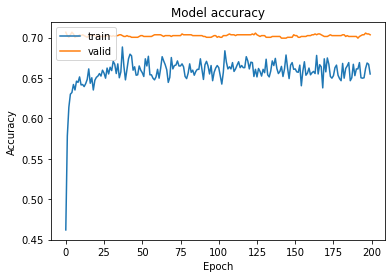

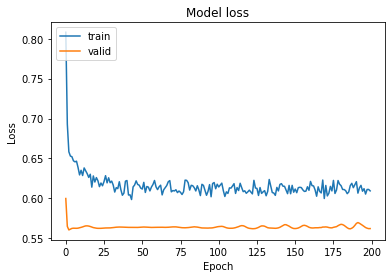

In [4]:
#collapse_hide
# build model

tf.keras.backend.clear_session()

def NCAA_Embeddings(nteams,teamEmb_size,embeddings_pretrained):
    team_input = Input(shape=[2,],dtype='int32', name='team_input')
    X_team = Embedding(input_dim=nteams, output_dim=teamEmb_size, input_length=2, weights=[embeddings_pretrained], trainable=False, name='team_encoding')(team_input)
    X = Dropout(rate=.5)(X_team)
    T1 = Lambda(lambda z: z[:,0,:])(X)
    T2 = Lambda(lambda z: z[:,1,:])(X)

    D1 = Dense(units = 80, use_bias=True, activation='tanh')
    DO1 = Dropout(rate=.5)

    D2 = Dense(units = 40, use_bias=True, activation='tanh')
    DO2 = Dropout(rate=.5)

    X1 = D1(T1)
    X1 = DO1(X1)

    X1 = D2(X1)
    X1 = DO2(X1)

    X2 = D1(T2)
    X2 = DO1(X2)

    X2 = D2(X2)
    X2 = DO2(X2)

    X_sub = Subtract()([X1,X2])
    
    X_sub = Dense(units = 5, use_bias=False, activation='tanh')(X_sub)

    output_w= Dense(units = 1, use_bias=False, activation='sigmoid', name='win_output')(X_sub)


    model = Model(inputs=team_input, outputs=output_w,name='ncaa_embeddings_joint')

    return model

modelEmbeddings = NCAA_Embeddings(len(id_to_oh),8,embeddings_pretrained)

#collapse_show
# Joint model
optimizer = Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=.001)
modelEmbeddings.compile(loss=['binary_crossentropy'],
#                 loss_weights=[0.5,400],
                optimizer=optimizer,
                metrics = ['accuracy'])
numBatch = round(X_train[0].shape[0]/1)
results = modelEmbeddings.fit(X_train[0], Y_train, validation_data=(X_valid[0], Y_valid), epochs = 200, batch_size = numBatch, shuffle=True, verbose=False)



#collapse_hide
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
# summarize history for accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Results on test data

In [5]:
#collapse_hide
def transform_y(preds,stats_cache):
    preds = stats_cache['var'][1] * preds + stats_cache['mean'][1]
    return preds

preds = modelEmbeddings.predict(X_test[0]).reshape(-1)

true = Y_test.reshape(-1)

loss=0
for ii in range(len(true)):
    if true[ii]==1:
        loss -= np.log(preds[ii])
    else:
        loss -= np.log(1-preds[ii])
loss = loss/len(true)

print('Model with embeddings only:')
print('accuracy',np.sum((1 - np.abs(preds - true)))/len(true))
print('loss',loss)


Model with embeddings only:
accuracy 0.60370071361314
loss 0.5570202676697321


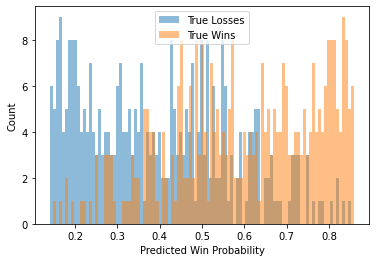

In [6]:
#collapse_hide
ywin = []
yloss = []
for ii in range(len(preds)):
    if Y_test[ii]==1:
        ywin += [preds[ii]]
    else:
        yloss += [preds[ii]]

plt.hist(yloss,bins=100, alpha=.5, label='True Losses')
plt.hist(ywin,bins=100, alpha=.5, label='True Wins')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Count')
plt.legend(loc="upper center")
plt.show()

In the plot above take note of the distribution of incorrectly predicted games >0.7 and <0.3. Compared to the other models, it appears the embeddings model makes less errors in this high-confidence range.

## Network using aggregated data only

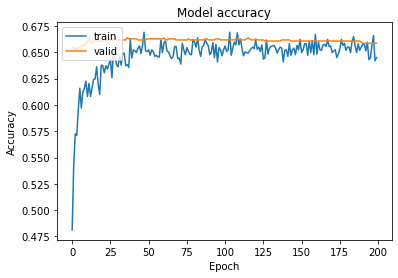

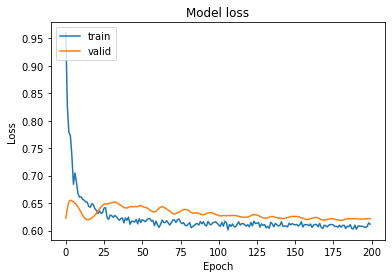

In [7]:
#collapse_hide
# build model

tf.keras.backend.clear_session()
mymodel = None

def NCAA_Aggregated(nteams,teamEmb_size,embeddings_pretrained):
    agg1_input = Input(shape=[2,],dtype='float32', name='agg_input1')
    agg2_input = Input(shape=[2,],dtype='float32', name='agg_input2')

    D1 = Dense(units = 80, use_bias=True, activation='tanh')
    DO1 = Dropout(rate=.5)

    D2 = Dense(units = 40, use_bias=True, activation='tanh')
    DO2 = Dropout(rate=.5)

    X1 = D1(agg1_input)
    X1 = DO1(X1)

    X1 = D2(X1)
    X1 = DO2(X1)

    X2 = D1(agg2_input)
    X2 = DO1(X2)

    X2 = D2(X2)
    X2 = DO2(X2)

    X_sub = Subtract()([X1,X2])
    
    X_sub = Dense(units = 5, use_bias=False, activation='tanh')(X_sub)

    output_w= Dense(units = 1, use_bias=False, activation='sigmoid', name='win_output')(X_sub)


    model = Model(inputs=[agg1_input,agg2_input], outputs=output_w, name='ncaa_embeddings_joint')

    return model


modelAggregated = NCAA_Aggregated(len(id_to_oh),8,embeddings_pretrained)

#collapse_show
# Joint model
optimizer = Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=.001)
modelAggregated.compile(loss=['binary_crossentropy'],
#                 loss_weights=[0.5,400],
                optimizer=optimizer,
                metrics = ['accuracy'])
numBatch = round(X_train[0].shape[0]/1)
results = modelAggregated.fit(X_train[1:], Y_train, validation_data=(X_valid[1:], Y_valid), epochs = 200, batch_size = numBatch, shuffle=True, verbose=False)



#collapse_hide
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
# summarize history for accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Results on test data

In [8]:
#collapse_hide
def transform_y(preds,stats_cache):
    preds = stats_cache['var'][1] * preds + stats_cache['mean'][1]
    return preds

preds = modelAggregated.predict(X_test[1:]).reshape(-1)

true = Y_test.reshape(-1)

loss=0
for ii in range(len(true)):
    if true[ii]==1:
        loss -= np.log(preds[ii])
    else:
        loss -= np.log(1-preds[ii])
loss = loss/len(true)

print('Model with aggregated statistics only:')
print('accuracy',np.sum((1 - np.abs(preds - true)))/len(true))
print('loss',loss)


Model with aggregated statistics only:
accuracy 0.5983709992757484
loss 0.5982060400552102


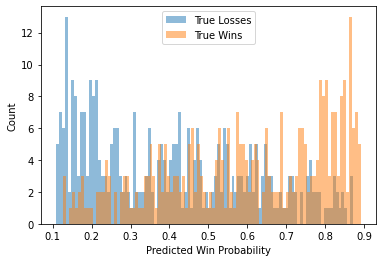

In [9]:
#collapse_hide
ywin = []
yloss = []
for ii in range(len(preds)):
    if Y_test[ii]==1:
        ywin += [preds[ii]]
    else:
        yloss += [preds[ii]]

plt.hist(yloss,bins=100, alpha=.5, label='True Losses')
plt.hist(ywin,bins=100, alpha=.5, label='True Wins')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Count')
plt.legend(loc="upper center")
plt.show()

The model built using only the aggregated statistics incorrectly predicts more of the high confidence predictions (>0.7 or <0.3) in comparison to the embeddings model. We also see a lower overall accuracy and log loss when predicting the test set.

## Network using both aggregated data and embeddings

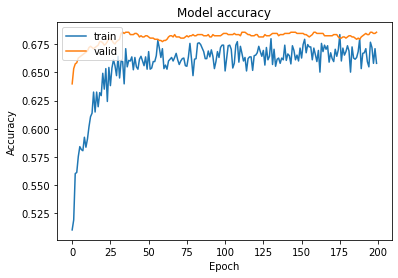

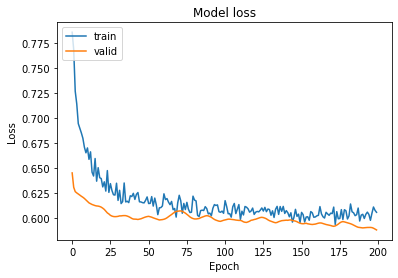

In [10]:
#collapse_hide
# build model

tf.keras.backend.clear_session()

def NCAA_EmbeddingsAgg(nteams,teamEmb_size,embeddings_pretrained):
    team_input = Input(shape=[2,],dtype='int32', name='team_input')
    X_team = Embedding(input_dim=nteams, output_dim=teamEmb_size, input_length=2, weights=[embeddings_pretrained], trainable=False, name='team_encoding')(team_input)
    X = Dropout(rate=.5)(X_team)
    T1 = Lambda(lambda z: z[:,0,:])(X)
    T2 = Lambda(lambda z: z[:,1,:])(X)
    
    agg1_input = Input(shape=[2,],dtype='float32', name='agg_input1')
    agg2_input = Input(shape=[2,],dtype='float32', name='agg_input2')
    
    X1 = Concatenate()([T1,agg1_input])
    X2 = Concatenate()([T2,agg2_input])

    D1 = Dense(units = 40, use_bias=True, activation='tanh')
    DO1 = Dropout(rate=.5)

    D2 = Dense(units = 20, use_bias=True, activation='tanh')
    DO2 = Dropout(rate=.5)

    X1 = D1(X1)
    X1 = DO1(X1)

    X1 = D2(X1)
    X1 = DO2(X1)

    X2 = D1(X2)
    X2 = DO1(X2)

    X2 = D2(X2)
    X2 = DO2(X2)

    X_sub = Subtract()([X1,X2])
    
    X_sub = Dense(units = 5, use_bias=False, activation='tanh')(X_sub)

    output_w= Dense(units = 1, use_bias=False, activation='sigmoid', name='win_output')(X_sub)


    model = Model(inputs=[team_input,agg1_input,agg2_input], outputs=output_w, name='ncaa_embeddings_joint')

    return model

modelEmbeddingsAgg = NCAA_EmbeddingsAgg(len(id_to_oh),8,embeddings_pretrained)

#collapse_show
# Joint model
optimizer = Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, amsgrad=False, decay=.001)
modelEmbeddingsAgg.compile(loss=['binary_crossentropy'],
#                 loss_weights=[0.5,400],
                optimizer=optimizer,
                metrics = ['accuracy'])
numBatch = round(X_train[0].shape[0]/1)
results = modelEmbeddingsAgg.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs = 200, batch_size = numBatch, shuffle=True, verbose=False)


#collapse_hide
accuracy = results.history['accuracy']
val_accuracy = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
# summarize history for accuracy
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Results on test data

In [11]:
#collapse_hide
def transform_y(preds,stats_cache):
    preds = stats_cache['var'][1] * preds + stats_cache['mean'][1]
    return preds

preds = modelEmbeddingsAgg.predict(X_test).reshape(-1)

true = Y_test.reshape(-1)

loss=0
for ii in range(len(true)):
    if true[ii]==1:
        loss -= np.log(preds[ii])
    else:
        loss -= np.log(1-preds[ii])
loss = loss/len(true)

print('Model with embeddings and aggregated statistics:')
print('accuracy',np.sum((1 - np.abs(preds - true)))/len(true))
print('loss',loss)


Model with embeddings and aggregated statistics:
accuracy 0.6116241328307053
loss 0.569799951818331


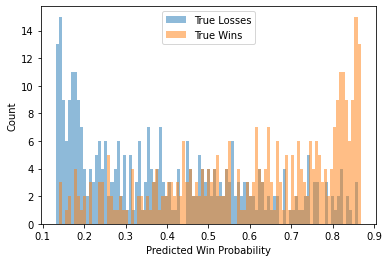

In [12]:
#collapse_hide
ywin = []
yloss = []
for ii in range(len(preds)):
    if Y_test[ii]==1:
        ywin += [preds[ii]]
    else:
        yloss += [preds[ii]]

plt.hist(yloss,bins=100, alpha=.5, label='True Losses')
plt.hist(ywin,bins=100, alpha=.5, label='True Wins')
plt.xlabel('Predicted Win Probability')
plt.ylabel('Count')
plt.legend(loc="upper center")
plt.show()

The hybrid model performs better than the model trained using only aggregated statistics, but worse than the model using only the embeddings.

## Conclusions
The model trained from the embeddings clearly outperformed the model trained from the aggregated regular season data. Despite the uplift, the best results here (loss of 0.56 using embeddings) are still worse than a model built using the more detailed tournament data with advanced statistics (can be in the ballpark of 0.50). These results are promising! More work is needed to test if embeddings provide uplift a more detailed model.